# Deep convolutional neural network binary classifier

__Author:__ John Leung

__Content:__ This program is a CNN using the keras framework. It accepts a train set of labeled data (X_train, Y_train) to train the weights of the network. Then it tests it on a test set (X_test, Y_test). The architecture of of the CNN follows input → Conv → FC → output, with built-in dropout, max-pooling, ResNet and batch normalization. The task involved in the default data is to identify whether a person is smiling (y=1) or not (y=0). The default image size is 64×64 with 3 channels (RGB).

This program is inspired by and use data source from the course on [Convolutional Neural Network](https://www.coursera.org/learn/convolutional-neural-networks) provided by __deeplearning.ai__ on __Coursera__.

In [1]:
import numpy as np
from keras import layers
from keras import optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


Loading the data set. We use the convention X:{examples, feature_width, feature_height, feature_depth (color)} and Y:{samples, 1}.

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


## Create a fast model
Create and compile a model in a sequential manner and immediately evaluate it on the test set using "accuracy" as the measure.

In [102]:
def create_model():
    # Build model
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding = 'same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis = 3))
    model.add(Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(axis = 3))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    adam = optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

fast_model = create_model()
fast_model.fit(x = X_train, y = Y_train, epochs = 40, batch_size = 16)

###################  test set evaluation ######################
preds = CNNModel.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Epoch 1/40
600/600 [==============================] - 2s 3ms/step - loss: 0.4973 - accuracy: 0.7550
Epoch 2/40
600/600 [==============================] - 1s 2ms/step - loss: 0.2589 - accuracy: 0.9117
Epoch 3/40
600/600 [==============================] - 1s 2ms/step - loss: 0.1897 - accuracy: 0.9367
Epoch 4/40
600/600 [==============================] - 1s 2ms/step - loss: 0.1503 - accuracy: 0.9517
Epoch 5/40
600/600 [==============================] - 1s 2ms/step - loss: 0.1084 - accuracy: 0.9800
Epoch 6/40
600/600 [==============================] - 1s 2ms/step - loss: 0.1101 - accuracy: 0.9767
Epoch 7/40
600/600 [==============================] - 1s 2ms/step - loss: 0.1023 - accuracy: 0.9733
Epoch 8/40
600/600 [==============================] - 1s 2ms/step - loss: 0.0756 - accuracy: 0.9850
Epoch 9/40
600/600 [==============================] - 1s 2ms/step - loss: 0.0836 - accuracy: 0.9750
Epoch 10/40
600/600 [==============================] - 1s 2ms/step - loss: 0.0839 - accuracy: 0.9833

## Building CNN with block architecture

Designing a deeper and more complicated model using a block architecture. We define, as a baseline, we define two kinds of block: The convolutional (Conv) block with 2D filters, and the fully-connected (FC) block that unrolls the 2D activations to a vector and sets up a fully-connected neural network.

In [3]:
def Conv_block(X, f, s, n_filters, name, pad = 'same', pooling = 1, ResNet = False, X_shortcut = None, dropout = 0.):
    """
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- filter size (int), f_w = f_h = f
    s -- stride (integer), s_w = s_h = s
    p -- padding (str), 'valid' or 'same'
    n_filters -- number of filter (int), depth of the CONV
    pooling -- pooling filter size (int), using max_pooling
    dropout -- dropout rate (float), 0. <= f < 1.0
    name -- name of the layer (str)
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name = 'conv_' + name
    do_name = 'do_' + name
    bn_name = 'bn_' + name
    pl_name = 'pool_' + name
    
    if dropout > 0:
        X = Dropout(dropout, name=do_name)(X)
    
    X = Conv2D(filters = n_filters, kernel_size = (f,f), strides = (s,s), padding = pad, name = conv_name)(X)
    X = BatchNormalization(axis = 3, name = bn_name)(X)

    if ResNet:
        X = Add()([X_shortcut,X])
        
    X = Activation('relu')(X)

    if pooling > 1:
        X = MaxPooling2D((pooling, pooling), name=pl_name, padding = pad)(X)
    
    return X

In [4]:
def FC_block(X, n_filters, name, activation = 'relu', flattenX = False):

    fc_name = 'fc_' + name

    if flattenX:
        X = Flatten()(X)
        
    X = Dense(n_filters, activation=activation, name=fc_name)(X)

    if activation == 'relu':
        bn_name = 'bn_' + name
        X = BatchNormalization(name = bn_name)(X)
        
    return X

## Building the model with blocks

Constructing a CNN model by linking the previously defined block modules.

In [5]:
def CNN_Model(input_shape):
    X_input = Input(input_shape)
    
    ################# pre-CNN processing ################
    X = X_input
    #####################################################

    ###################### Convolutional Blocks ######################
    X = Conv_block(X, f=5, s=2, n_filters=32, name='L1',dropout = 0.2)
    X = Conv_block(X, f=3, s=1, n_filters=16, name='L2', pooling = 2, dropout = 0.2)
    X = Conv_block(X, f=1, s=1, n_filters=8, name='L3')
    ##################################################################
    
    ##################### Fully-Connected blocks #####################
    X = FC_block(X, n_filters=8, name='L4', flattenX = True)
    X = FC_block(X, n_filters=1, name='L5', activation = 'sigmoid')
    ##################################################################
    
    ################ Create  Keras model instance ################
    model = Model(inputs = X_input, outputs = X, name='Face_Model')
    return model

## Compiling and testing models

Define an optimizer and compile the CNN model set-up in the previous section. The model is then fitted to the train set (X_train, Y_train). The default setting is a size 16 mini-batch with Adam optimizer over 40 epochs. Then, the trained model is tested in 2 ways: against the test set (X_test, Y_test) using accuracy as the measure; and comparing some individual photos in the _images/_ folder (size 64×64).

In [6]:
adam = optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999)
CNNModel = CNN_Model(X_train.shape[1:])
CNNModel.summary()
CNNModel.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])
CNNModel.fit(x = X_train, y = Y_train, epochs = 40, batch_size = 16)

Model: "Face_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
do_L1 (Dropout)              (None, 64, 64, 3)         0         
_________________________________________________________________
conv_L1 (Conv2D)             (None, 32, 32, 32)        2432      
_________________________________________________________________
bn_L1 (BatchNormalization)   (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
do_L2 (Dropout)              (None, 32, 32, 32)        0         
_________________________________________________________________
conv_L2 (Conv2D)             (None, 32, 32, 16)        4

In [7]:
preds = CNNModel.evaluate(x = X_test, y = Y_test)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 1ms/step
Loss = 0.177463478645
Test Accuracy = 0.946666657925


[[1.]]


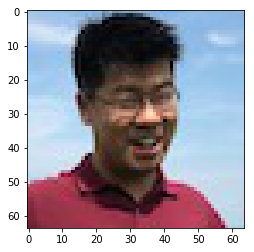

In [10]:
img_path = 'images/image1.jpg'

img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(CNNModel.predict(x))